# Open3D C++ and Python Interaction

For this tutorial we will be using the plane segmentation algorithm in Open3D. You can already see an example on the [official documentation](http://www.open3d.org/docs/latest/tutorial/Basic/pointcloud.html#Plane-segmentation)

## Load the data

We are using the first scan of the sequence 07 of the KITTI dataset, just because

In [1]:
import open3d as o3d
import open3d_jupyter_draw_geometries

In [2]:
pcd = o3d.io.read_point_cloud('./kitti_seq_07_scan_000000.ply')

## Initial inspection of the data

KITTI Sequence 07 scan:


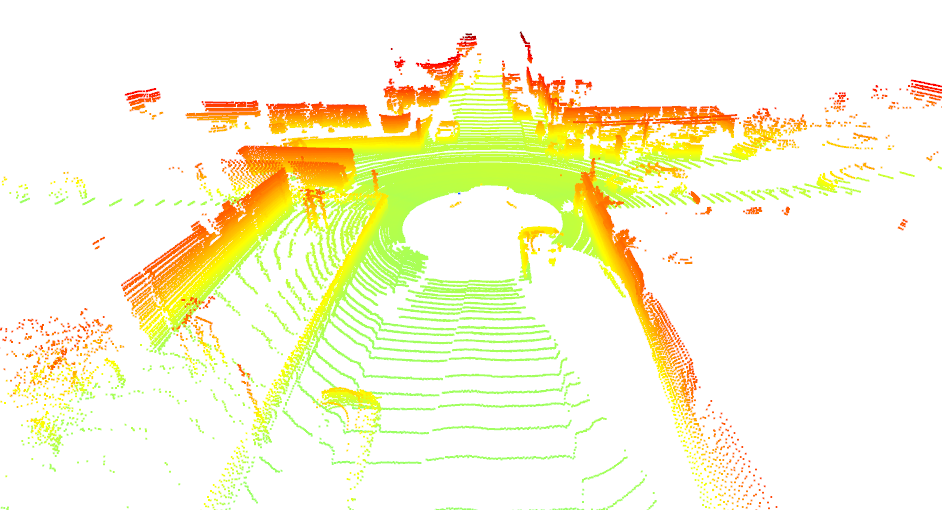

In [3]:
print("KITTI Sequence 07 scan:")
o3d.visualization.draw_geometries([pcd],
                                  point_size=2,
                                  front=[-0.86, -0.13, 0.49],
                                  lookat=[2.53, 1.12, -5.31],
                                  up=[0.49, 0.05, 0.87],
                                  zoom=0.1)

## Inspect the Segmentation algorithm

You could read the offical documentation as well, or check the implementation but let's use python for this

In [4]:
o3d.geometry.PointCloud.segment_plane?
help(o3d.geometry.PointCloud.segment_plane)

Help on instancemethod in module open3d.cpu.pybind.geometry:

segment_plane(...)
    segment_plane(self, distance_threshold, ransac_n, num_iterations)
    
    Segments a plane in the point cloud using the RANSAC algorithm.
    
    Args:
        distance_threshold (float): Max distance a point can be from the plane model, and still be considered an inlier.
        ransac_n (int): Number of initial points to be considered inliers in each iteration.
        num_iterations (int): Number of iterations.
    
    Returns:
        Tuple[numpy.ndarray[float64[4, 1]], List[int]]



## Parameter tunning

As you can see there are 3 parameters to tune here:
 - **`distance_threshold`** defines the maximum distance a point can have to an estimated plane to be considered an inlier
 - **`ransac_n`** defines the number of points that are randomly sampled to estimate a plane
 - **`num_iterations`** defines how often a random plane is sampled and verified. 
 
The function then returns the plane as $(a,b,c,d)$ such that for each point $(x,y,z)$ on the plane we have $ax + by + cz + d = 0$. The function further returns a list of indices of the inlier points.

In [5]:
distance_threshold = 0.2
ransac_n = 3
num_iterations = 1000

In [6]:
_, plane_points = pcd.segment_plane(distance_threshold=distance_threshold,
                                    ransac_n=ransac_n,
                                    num_iterations=num_iterations)

Results of the plane segmentation:


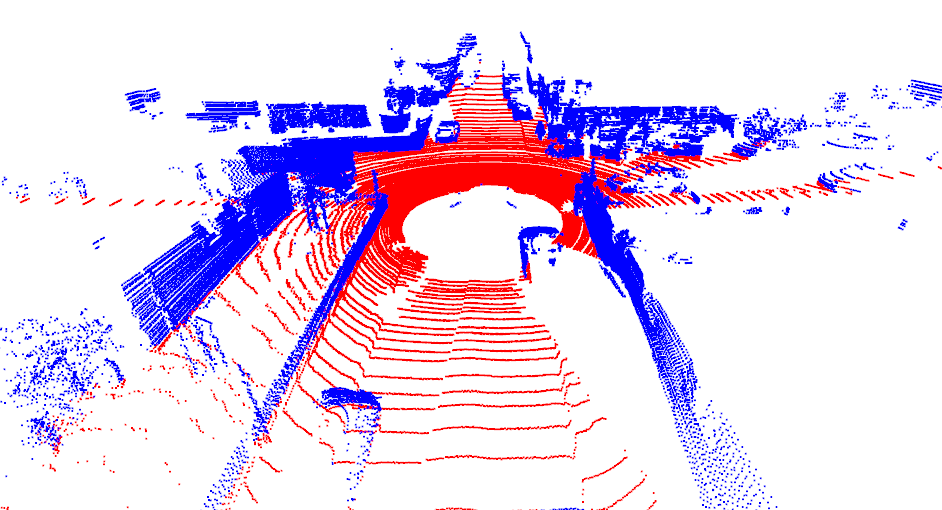

In [7]:
plane_cloud = pcd.select_by_index(plane_points)
plane_cloud.paint_uniform_color([1.0, 0, 0])

rest_cloud = pcd.select_by_index(plane_points, invert=True)
rest_cloud.paint_uniform_color([0, 0, 1.0])

print("Results of the plane segmentation:")
o3d.visualization.draw_geometries([plane_cloud, rest_cloud],
                                  point_size=2,
                                  front=[-0.86, -0.13, 0.49],
                                  lookat=[2.53, 1.12, -5.31],
                                  up=[0.49, 0.05, 0.87],
                                  zoom=0.1)

## Improve visualization

To better analyze the results we can improve the visualization by only showing the plane points:

Plane cloud only:


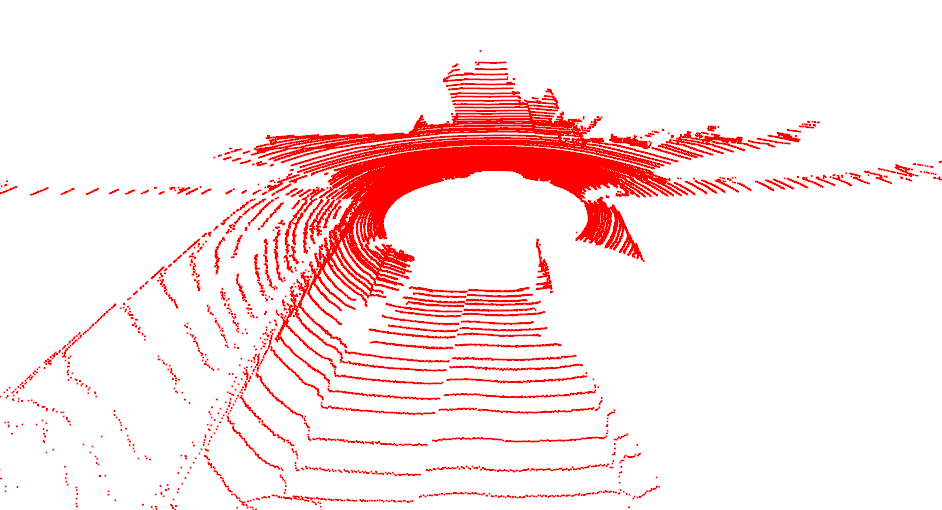

In [8]:
print("Plane cloud only:")
o3d.visualization.draw_geometries([plane_cloud],
                                  point_size=2,
                                  front=[-0.86, -0.13, 0.49],
                                  lookat=[2.53, 1.12, -5.31],
                                  up=[0.49, 0.05, 0.87],
                                  zoom=0.1)

## Report 

In [24]:
total_n_points = len(pcd.points)
planar_n_points = len(plane_cloud.points)
rest_n_points = len(rest_cloud.points)

print("Original cloud had {} points".format(total_n_points))
print("Plane cloud has {} points".format(planar_n_points))
print("Plane cloud represents {} % of the original cloud".format(
    int(100 * planar_n_points / total_n_points)))

Original cloud had 122626 points
Plane cloud has 54310 points
Plane cloud represents 44 % of the original cloud


## Simple benchmark

One thing you can try right away on Jupyter notebooks is to "benchmark" the method. This doesn't replace a real benchmarking but at least will give you an idea of how fast/slow is the method. Just add `%%timeit` at the top of the cell

In [9]:
%%timeit
_, plane_points = pcd.segment_plane(distance_threshold=distance_threshold,
                                    ransac_n=ransac_n,
                                    num_iterations=num_iterations)

1.47 s ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Timing analysis

As you can see, if this algorithm is taking around `1.5 seconds` on a multicore desktop CPU, it will be very likely that you will be able to run this out of the box on an embedded platform. When you use the Open3D C++ API you will gain some extra miliseconds on the execution but it won't be much. If you reach this point without compiling any C++ file, then you already saved quite lot of time, since during the prototyping stage you were able to draw some conclusions without writing "real code", congratulations!

## C++ API

Even when this won't be able to run on a real system, let's use the same parameters we obtained by expermentation on this notebook and create a small C++ application that recreates the same data pipeline. Now let's open [PointCloud](./PlaneSegmentation.cpp)

### How to build the C++ example

```sh
mkdir -p build && cmake .. && make
```

### How to run the C++ example

```sh
./PlaneSegmentation kitti_seq_07_scan_000000.ply
```